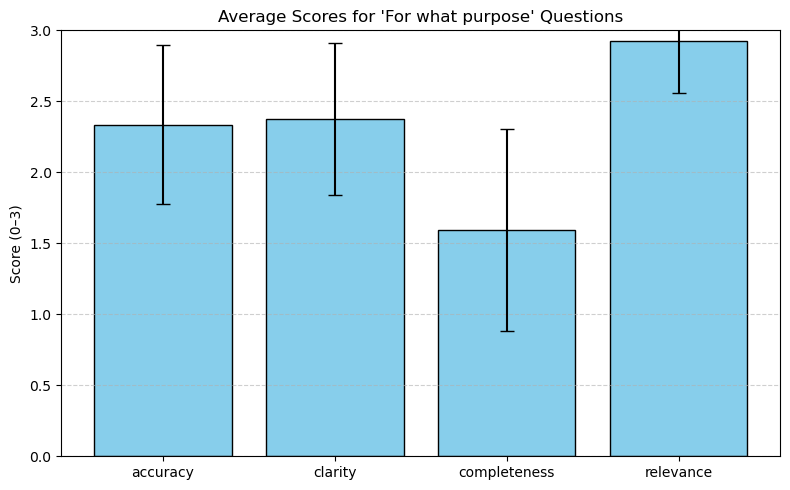

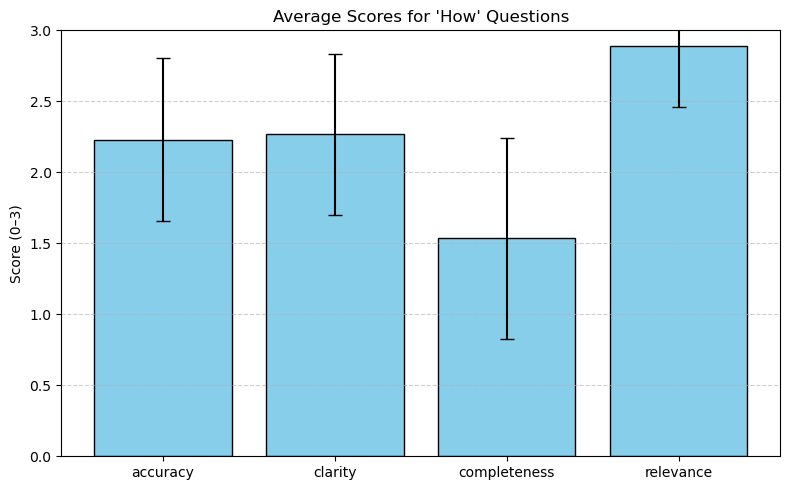

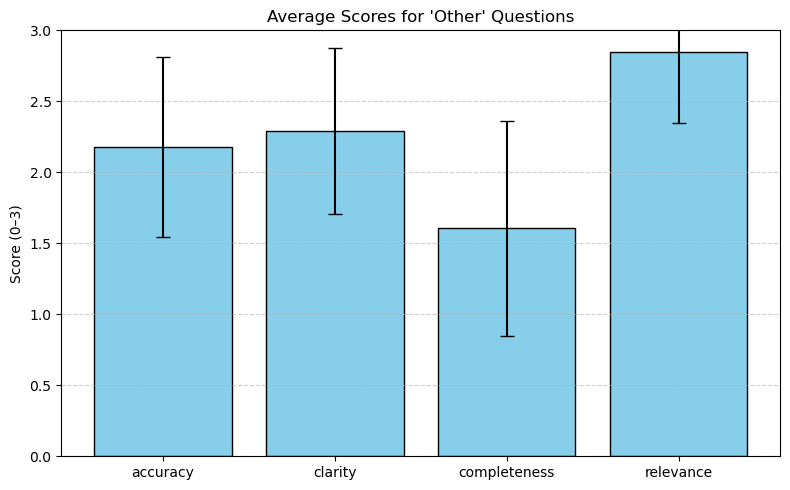

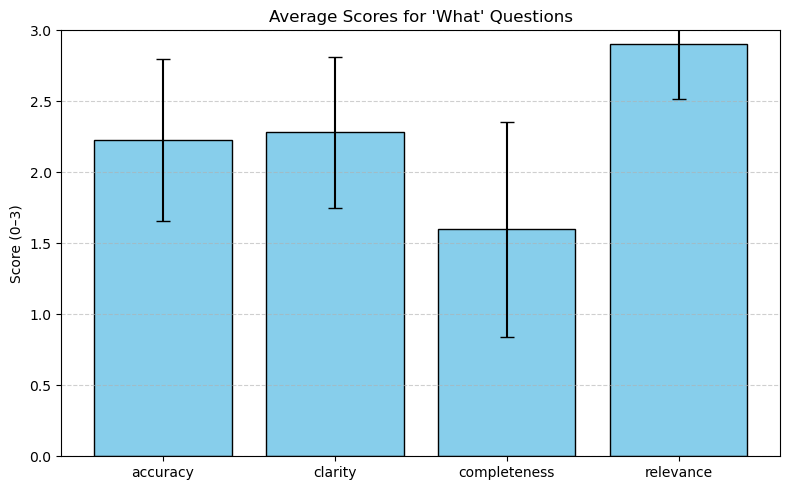

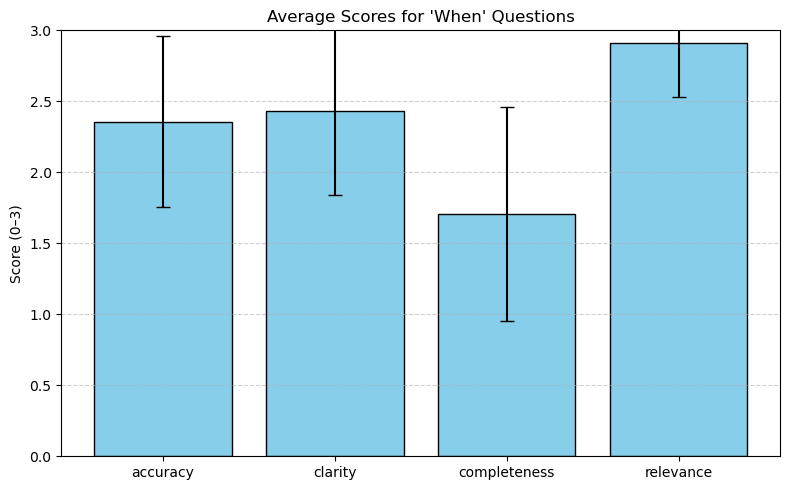

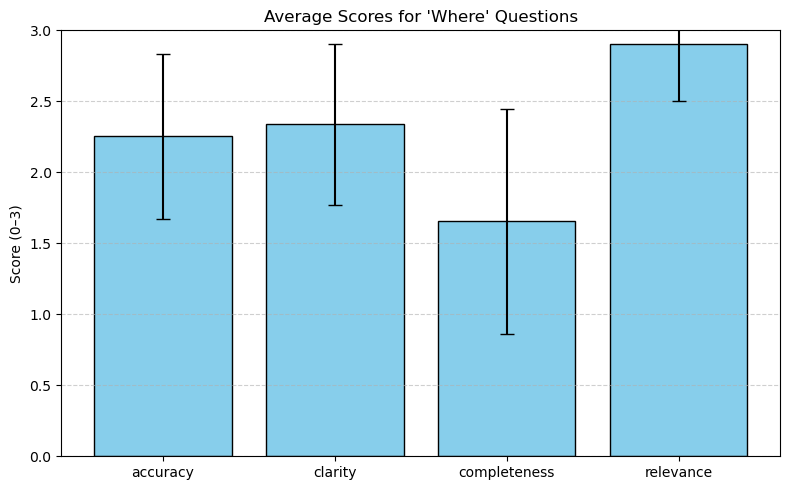

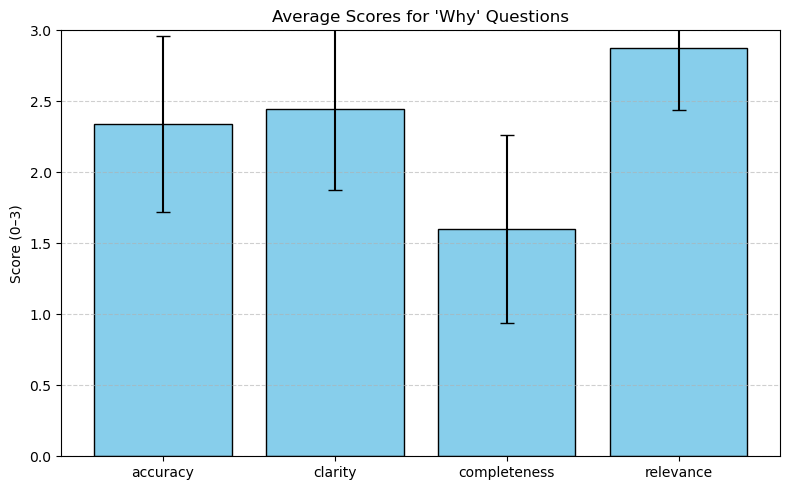

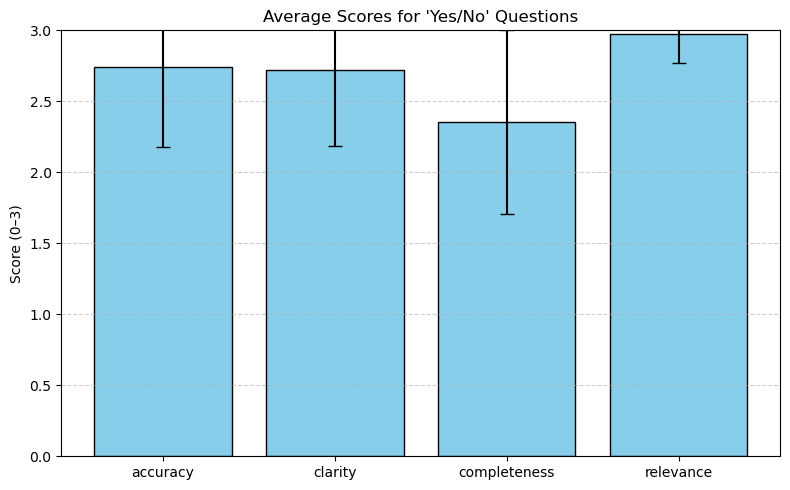

,Question Type,Accuracy,Completeness,Clarity,Relevance
0,For what purpose,2.34 (0.56),1.60 (0.71),2.38 (0.54),2.92 (0.36)
1,How,2.23 (0.58),1.53 (0.71),2.27 (0.57),2.89 (0.43)
2,Other,2.18 (0.63),1.61 (0.76),2.29 (0.59),2.85 (0.50)
3,What,2.23 (0.57),1.60 (0.76),2.28 (0.53),2.91 (0.39)
4,When,2.36 (0.60),1.71 (0.76),2.43 (0.59),2.91 (0.38)
5,Where,2.25 (0.58),1.65 (0.79),2.34 (0.57),2.90 (0.40)
6,Why,2.34 (0.62),1.60 (0.66),2.45 (0.57),2.87 (0.44)
7,Yes/No,2.74 (0.56),2.35 (0.65),2.72 (0.53),2.97 (0.21)


In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Load the dataset ===
with open("CodeLlama_CodeQA_llm_judge.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# === Step 2: Classify question types ===
def classify_question_type(q):
    q_lower = q.lower()
    if q_lower.startswith("what"):
        return "What"
    elif q_lower.startswith("how"):
        return "How"
    elif q_lower.startswith("where"):
        return "Where"
    elif q_lower.startswith("when"):
        return "When"
    elif q_lower.startswith("why"):
        return "Why"
    elif q_lower.startswith("for what purpose"):
        return "For what purpose"
    elif q_lower.startswith(("does", "do", "is", "are", "can")):
        return "Yes/No"
    else:
        return "Other"

df["question_type"] = df["question"].apply(classify_question_type)

# === Step 3: Extract score values from nested structure ===
metrics = ["accuracy", "clarity", "completeness", "relevance"]
for metric in metrics:
    df[metric] = df[metric].apply(lambda x: x.get("score") if isinstance(x, dict) else None)

# === Step 4: Generate plots for each question type ===
def visualize_scores(flat_records, title):
    df_scores = pd.DataFrame(flat_records)
    grouped = df_scores.groupby("metric")["score"]
    avg_scores = grouped.mean()
    std_scores = grouped.std().fillna(0)

    plt.figure(figsize=(8, 5))
    plt.bar(
        avg_scores.index,
        avg_scores.values,
        yerr=std_scores.values,
        capsize=5,
        color='skyblue',
        edgecolor='black'
    )
    plt.title(title)
    plt.ylabel("Score (0–3)")
    plt.ylim(0, 3)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

for qtype, subset in df.groupby("question_type"):
    flat_records = []
    for metric in metrics:
        for score in subset[metric].dropna():
            flat_records.append({"metric": metric, "score": score})
    if flat_records:
        visualize_scores(flat_records, title=f"Average Scores for '{qtype}' Questions")

# === Step 5: Create a summary table ===
summary = []
for qtype, subset in df.groupby("question_type"):
    row = {"Question Type": qtype}
    for metric in metrics:
        mean_val = subset[metric].mean()
        std_val = subset[metric].std()
        if pd.notna(mean_val) and pd.notna(std_val):
            row[metric.capitalize()] = f"{mean_val:.2f} ({std_val:.2f})"
        elif pd.notna(mean_val):
            row[metric.capitalize()] = f"{mean_val:.2f} (0.00)"
        else:
            row[metric.capitalize()] = "N/A"
    summary.append(row)

summary_df = pd.DataFrame(summary)
summary_df = summary_df[["Question Type", "Accuracy", "Completeness", "Clarity", "Relevance"]]
summary_df = summary_df.round(2)

# === Display the table ===
from IPython.display import display
display(summary_df)
